<a href="https://colab.research.google.com/github/danyamrajuSanjay/Machine_Learning/blob/master/AI_Capstone_detecting_cracks_PyTorch_vs_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import os
import torch
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd
import numpy as np

Reading image data from IBM storage

In [3]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P /resources/data

--2020-09-01 04:50:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘/resources/data/concrete_crack_images_for_classification.zip’

concrete_crack_imag 100%[===================>] 233.90M  23.5MB/s    in 10s     

2020-09-01 04:50:22 (23.2 MB/s) - ‘/resources/data/concrete_crack_images_for_classification.zip’ saved [245259777/245259777]



Unzipping the data into resources/data directory

In [4]:
!unzip -q  /resources/data/concrete_crack_images_for_classification.zip -d  /resources/data

In [5]:
directory="/resources/data"

function read images from positive and negative directory that ends with .jpg

In [6]:
def get_path(type_file):
  negative_file_path=os.path.join(directory,type_file)
  negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
  negative_files.sort()
  return negative_files

fetching images from negative directory


In [7]:
negative_files=get_path('Negative')
negative_files[:3]

['/resources/data/Negative/00001.jpg',
 '/resources/data/Negative/00002.jpg',
 '/resources/data/Negative/00003.jpg']

fetching images from positive directory

In [8]:
positive_files=get_path('Positive')
positive_files[:3]

['/resources/data/Positive/00001.jpg',
 '/resources/data/Positive/00002.jpg',
 '/resources/data/Positive/00003.jpg']

Printing first 3 images of positive samples

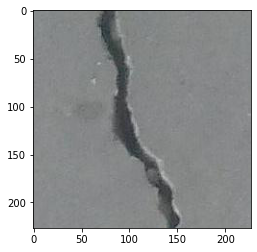

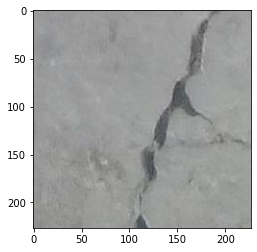

In [9]:
for img in range(2):
  positive_image=mpimg.imread(positive_files[img])
  plt.imshow(positive_image)
  plt.show()

Printing first 3 images of negative samples

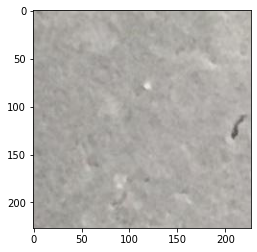

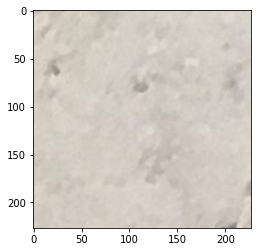

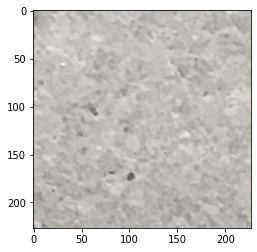

In [10]:
for img in range(3):  
  negative_image=Image.open(negative_files[img])
  plt.imshow(negative_image)
  plt.show()

# Data preparation using pytorch

In [11]:
import torch

In [12]:
total_samples=len(negative_files)+len(positive_files)
print(total_samples)

40000


Create Y, the target variable torch using the total samples

In [13]:
Y=torch.zeros([total_samples])
Y

tensor([0., 0., 0.,  ..., 0., 0., 0.])

assinging targets 0,1 to int

In [14]:
Y=Y.type(torch.LongTensor)

create target 1 for cracked/positive sample and 0 for negative sample
positive: even places
negative: odd places

In [15]:
Y[::2]=1
Y[1:2]=0

Creating all_files object that contain images that are positive in even indices and negative at odd indices

In [16]:
all_files=np.ravel([positive_files,negative_files],order='F')
all_files

array(['/resources/data/Positive/00001.jpg',
       '/resources/data/Negative/00001.jpg',
       '/resources/data/Positive/00002.jpg', ...,
       '/resources/data/Negative/19999.jpg',
       '/resources/data/Positive/20000.jpg',
       '/resources/data/Negative/20000.jpg'], dtype='<U36')

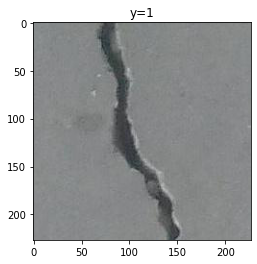

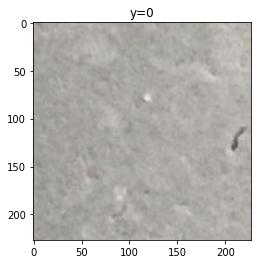

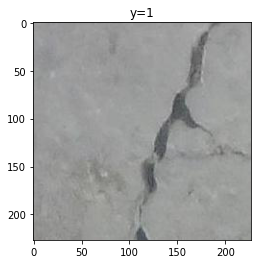

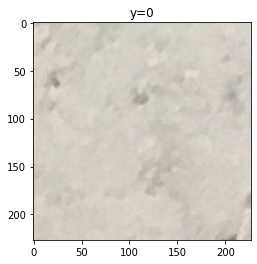

In [17]:
for y,file in zip(Y, all_files[0:4]):
    plt.imshow(Image.open(file))
    plt.title("y="+str(y.item()))
    plt.show()

using np.ravel to get sequence of positives one by one

In [18]:
all_files=np.ravel([positive_files+negative_files],order='F')
len(all_files)

40000

### Creating dataset using pytorch

In [40]:
from torch.utils.data import Dataset
import torch.nn as nn

In [20]:
class data(Dataset):
    def __init__(self,train=True,transform=None):
      directory="/resources/data"
      positive='Positive'
      negative='Negative'

      positive_file_path=os.path.join(directory,positive)
      negative_file_path=os.path.join(directory,negative)
      positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
      positive_files.sort()
      negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
      negative_files.sort()

      # self.all_files=np.ravel([positive_files+negative_files],order='F')
      total_samples=len(positive_files+negative_files)

      #or 
      self.all_files=[None]*total_samples
      self.all_files[::2]=positive_files
      self.all_files[1::2]=negative_files
      
      self.transform=transform
      self.Y=torch.zeros([total_samples]).type(torch.LongTensor)
      self.Y[::2]=1
      self.Y[1::2]=0


      if train:
        self.all_files=self.all_files[0:30000]
        self.Y=self.Y[0:30000]
        self.len=len(self.all_files)
      else:
        self.all_files=self.all_files[30000:]
        self.Y=self.Y[30000:]
        self.len=len(self.all_files)

    def __len__(self):
      return self.len

    def __getitem__(self,idx):
      image=Image.open(self.all_files[idx])
      y=self.Y[idx]

      if self.transform:
        image=self.transform(image)

      return image,y

In [21]:
import torchvision.transforms as transforms

image transforms

In [22]:
mean =[0.485,0.56,0.406]
std=[0.229,0.224,0.225]

transform=transforms.Compose([transforms.ToTensor, transforms.Normalize(mean,std)])

train and test validation split

In [24]:
dataset_train=data(train=True,transform=transform)
dataset_val=data(train=False,transform=transform)


In [25]:
size_of_image=3*27*27
size_of_image

2187

Custom Softmax module

In [41]:
class Softmax(nn.ModuleList):
  def __init__(self,in_size,out_size):
    super(Softmax,self).__init__()
    self.linear=nn.Linear(in_size,out_size)

  def forward(self,x):
    out=self.linear(x)
    return out



In [42]:
in_size=3*27*27
out_size=2
torch.manual_seed(0)

In [47]:
model=Softmax(in_size,out_size)
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 0.0014, -0.0186, -0.0094,  ...,  0.0042, -0.0076, -0.0004],
        [ 0.0058, -0.0008, -0.0179,  ..., -0.0086, -0.0164, -0.0090]])), ('linear.bias', tensor([-0.0011, -0.0178]))])


In [48]:
criterion=torch.nn.CrossEntropyLoss()

In [52]:
optimizer=torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.1)

In [55]:
from torch.utils.data import DataLoader

data_loader_train=DataLoader(dataset_train,batch_size=1000,shuffle=True)
data_loader_valid=DataLoader(dataset_val,batch_size=1000)

In [ ]:
train_loss=[]
validation_loss=[]
n_epochs=5
for epoch in range(n_epochs):
  

In [26]:
# dataset=data()
# samples=[9,100]
# for sample  in samples:
#     plt.imshow(dataset[sample][0])
#     plt.xlabel("y="+str(dataset[sample][1].item()))
#     plt.title("training data, sample {}".format(int(sample)))
#     plt.show()
    

In [27]:
# dataset_valid=data(train=False)
# samples=[15,102]
# for sample  in samples:
#     plt.imshow(dataset_valid[sample][0])
#     plt.xlabel("y="+str(dataset_valid[sample][1].item()))
#     plt.title("training data, sample {}".format(int(sample)))
#     plt.show()
    

# Data preparation using keras

In [28]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week2.zip

In [30]:
# !unzip concrete_data_week2.zip

In [31]:
# dataset_dir = './concrete_data_week2'
# os.listdir('concrete_data_week2')

In [32]:
# data_generator=ImageDataGenerator(rescale=1./255)

In [33]:
# image_generator=data_generator.flow_from_directory( 
#                                             dataset_dir,
#                                             batch_size=4,
#                                             class_mode='categorical',
#                                             seed=24
# )